In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SequentialSampler, Subset
from utils import get_lags, get_average, TrainHelper, Window, CoreDataset, evaluate_on_test, init_weights

In [2]:
lags = 3
full = pd.read_csv('normalised_growth.csv', index_col=0, header=[0], parse_dates=True)
coredata = CoreDataset(full, lags=lags, series=["CPIAUCSL", "A191RO1Q156NBEA", "UNRATE"])

In [3]:
length = len(coredata)
val_start = round(length * 0.8)
test_start = round(length * 0.9)

In [6]:
trainset = Subset(coredata, [i for i in range(val_start - 1)])
valset = Subset(coredata, [i for i in range(val_start, test_start - 1)])
testset = Subset(coredata, [i for i in range(test_start, length)])

trainloader = DataLoader(trainset, batch_size=1, 
                        shuffle=False,
                        sampler=SequentialSampler(trainset))

validationloader = DataLoader(valset, batch_size=1, shuffle=False,
                    sampler=SequentialSampler(valset))

testloader = DataLoader(testset, batch_size=1, shuffle=False,
                        sampler=SequentialSampler(testset))

window = Window(trainloader, validationloader)

In [7]:
# check if view works
for i, data in enumerate(testloader):
    y, X = data
    print(X.view(3, 1, 3)[0])
    break

tensor([[-0.1517,  1.6716, -0.3439]], dtype=torch.float64)


In [11]:
class LSTMNet(nn.Module):
    def __init__(self, lags, hidden_size):
        super(LSTMNet, self).__init__()
        self.lags = lags
        
        # input_size should match that in forward method
        self.gru = nn.GRU(input_size=3, hidden_size=hidden_size)
        self.fc = nn.Linear(hidden_size, 3)
        
    def forward(self, x):
        # input to lstm layer is (seq_len, batch, input_size)
        x, hidden = self.gru(x.view(self.lags, 1, 3))
        x = F.relu(x)
        x = self.fc(x)
        return x        
        
model = LSTMNet(lags=lags, hidden_size=12)

In [12]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [21]:
trainer = TrainHelper(percent = 0.97, manual = 50)
trainer.train_window(model, criterion, optimizer, window)

[epoch: 1] train loss: 0.079, val loss: 0.135
[epoch: 6] train loss: 0.076, val loss: 0.128
[epoch: 11] train loss: 0.072, val loss: 0.122
[epoch: 16] train loss: 0.070, val loss: 0.117
[epoch: 21] train loss: 0.067, val loss: 0.112
[epoch: 26] train loss: 0.064, val loss: 0.107
[epoch: 31] train loss: 0.062, val loss: 0.103
[epoch: 36] train loss: 0.060, val loss: 0.100
[epoch: 41] train loss: 0.058, val loss: 0.096
[epoch: 46] train loss: 0.057, val loss: 0.094
[epoch: 51] train loss: 0.056, val loss: 0.092


Continue training? True or False:  False


Finished window


In [17]:
# model.apply(init_weights)

/Users/fredchen/JupyterProjects/macro/utils.py:348: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


LSTMNet(
  (gru): GRU(3, 12)
  (fc): Linear(in_features=12, out_features=3, bias=True)
)

Average MSE on test set: 0.029888730472885074


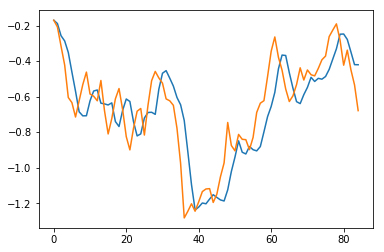

In [22]:
y_pred = []
y_act = []
running_test_loss = []

# evaluating LSTM is slightly different, only take last output in sequence
for i, data in enumerate(testloader):
    with torch.no_grad():
        y, X = data
        y, X = y.float(), X.float()
        
        loss = criterion(y, model(X))
        running_test_loss.append(loss.item())
    
        y_pred.append(model(X).squeeze()[lags-1][0].item())
        y_act.append(y.squeeze()[0].item())
    
plt.plot(y_pred)
plt.plot(y_act)

print("Average MSE on test set: " + str(get_average(running_test_loss)))

In [ ]:
# Wow. GRU is good...